In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime, timezone, date
from dateutil.relativedelta import relativedelta
from itertools import combinations

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import ccxt
import functions

import importlib
importlib.reload(functions)

sns.set_theme()


In [116]:
inst = ['ETH','UNI','SOL']
pairs = [('ETH','UNI'),('ETH','SOL')] #aave comp

In [117]:
today = date.today()
one_year_later = today - relativedelta(years=3)

In [118]:
# Create a datetime object for 2023-06-15 at midnight UTC
dt = datetime(one_year_later.year, one_year_later.month, one_year_later.day, 0, 0, 0, tzinfo=timezone.utc)

# Convert to Unix timestamp in milliseconds
timestamp_ms = int(dt.timestamp() * 1000)

In [119]:
df = functions.close_df(inst,timestamp_ms)

In [75]:
import numpy as np
import pandas as pd

# --- PP test adapter: tries statsmodels first, then arch ---
def _pp_test(resid, trend="c", lags=None):
    """
    Returns (stat, pvalue, crit_dict) using either statsmodels (if available) or arch.
    trend: 'n' (none), 'c' (const), 'ct' (const+trend)
    """
    # Try statsmodels (newer versions expose phillips_perron or PhillipsPerron)
    try:
        # Option 1: function API
        from statsmodels.tsa.stattools import phillips_perron
        stat, pvalue, crit = phillips_perron(resid, trend=trend, lags=lags)
        # statsmodels returns (stat, pvalue, crit_values) where crit is dict-like
        return float(stat), float(pvalue), dict(crit)
    except Exception:
        pass

    try:
        # Option 2: class API (some versions)
        from statsmodels.tsa.stattools import PhillipsPerron
        pp = PhillipsPerron(resid, trend=trend, lags=lags)
        # Attribute names vary a bit; handle both possibilities
        stat = getattr(pp, "stat", getattr(pp, "statistic", np.nan))
        pvalue = getattr(pp, "pvalue", np.nan)
        crit = getattr(pp, "critical_values", {})
        return float(stat), float(pvalue), dict(crit)
    except Exception:
        pass

    # Fall back to arch.unitroot
    try:
        from arch.unitroot import PhillipsPerron as ArchPP
        pp = ArchPP(resid, trend=trend, lags=lags)
        stat = getattr(pp, "stat", getattr(pp, "statistic", np.nan))
        pvalue = getattr(pp, "pvalue", np.nan)
        crit = getattr(pp, "critical_values", {})
        return float(stat), float(pvalue), dict(crit)
    except Exception as e:
        raise ImportError(
            "Phillips–Perron test not available. Install `arch` (pip install arch) "
            "or upgrade statsmodels."
        ) from e


def rolling_beta_pp_logs(
    df,
    x_col="UNI",             # independent variable (SOL)
    y_col="ETH",             # dependent variable (ETH)
    window=90,               # rolling window length
    include_intercept=True, # if True: y = alpha + beta*x
    trend="n",               # PP deterministic term: 'n','c','ct'
    lags=None,               # PP lag parameter (None = automatic per backend)
    min_obs=90               # minimum obs required
):
    """
    For each rolling 90-day window on LOG prices:
      1) estimate beta (and alpha if chosen) on the window,
      2) compute residuals on the SAME window,
      3) run Phillips–Perron unit-root test on residuals.
    Returns a DataFrame indexed by window_end with beta, PP stat/p-value/criticals, and a 5% stationarity flag.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df must have a DatetimeIndex.")

    # Prepare log prices
    data = df[[x_col, y_col]].copy()
    data = data[(data[x_col] > 0) & (data[y_col] > 0)].dropna()
    data = np.log(data).sort_index()

    n = len(data)
    if n < window:
        raise ValueError("Not enough data for the chosen window.")

    rows = []
    for end_idx in range(window - 1, n):
        start_idx = end_idx - (window - 1)
        w = data.iloc[start_idx:end_idx + 1]
        if len(w) < min_obs:
            continue

        x = w[x_col].values
        y = w[y_col].values

        # OLS on logs (with or without intercept)
        if include_intercept:
            X = np.column_stack([np.ones_like(x), x])
            (alpha, beta), *_ = np.linalg.lstsq(X, y, rcond=None)
        else:
            beta = float(np.dot(x, y) / np.dot(x, x))
            alpha = 0.0

        resid = y - (alpha + beta * x)

        # Phillips–Perron on residuals
        try:
            stat, pval, crit = _pp_test(resid, trend=trend, lags=lags)
            crit1 = crit.get("1%", np.nan)
            crit5 = crit.get("5%", np.nan)
            crit10 = crit.get("10%", np.nan)
        except Exception:
            stat = pval = crit1 = crit5 = crit10 = np.nan

        rows.append({
            "window_start": w.index[0],
            "window_end": w.index[-1],
            "alpha": alpha if include_intercept else np.nan,
            "beta": beta,
            "pp_stat": stat,
            "pvalue": pval,
            "crit_1pct": crit1,
            "crit_5pct": crit5,
            "crit_10pct": crit10,
            "stationary_5pct": (pval < 0.05) if (pval == pval) else np.nan
        })

    out = pd.DataFrame(rows).set_index("window_end")
    return out

# --- Example usage ---
# results = rolling_beta_pp_logs(df, x_col="SOL", y_col="ETH", window=90, include_intercept=False, trend="c", lags=None)
# print(results.tail())
# print("Stationarity hit-rate (5%):", results["stationary_5pct"].mean())


In [76]:
test = rolling_beta_pp_logs(df)

KeyError: "['UNI'] not in index"

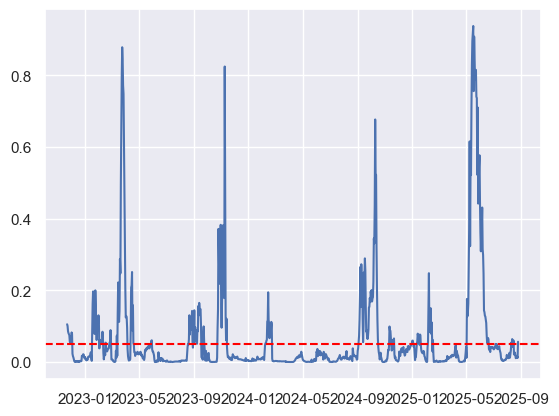

In [77]:

plt.plot(test['pvalue'])
plt.axhline(0.05, color="red", linestyle="--", label="5% threshold")

In [78]:
test[test['pvalue']<=0.5].index

DatetimeIndex(['2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-26', '2022-11-27', '2022-11-28', '2022-11-29',
               '2022-11-30', '2022-12-01',
               ...
               '2025-08-16', '2025-08-17', '2025-08-18', '2025-08-19',
               '2025-08-20', '2025-08-21', '2025-08-22', '2025-08-23',
               '2025-08-24', '2025-08-25'],
              dtype='datetime64[ns]', name='window_end', length=976, freq=None)

KeyError: 'UNI'

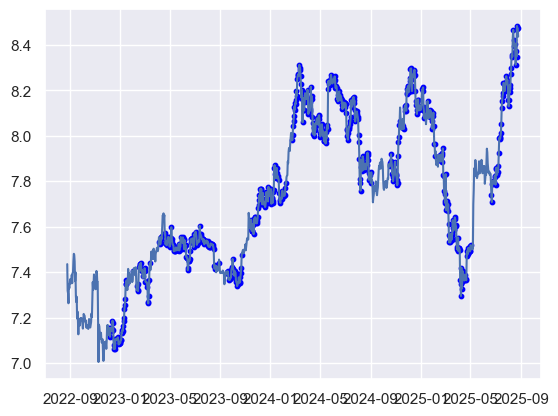

In [79]:
#plt.plot(np.log(df['ETH'][test['pvalue']<= 0.05]))
# ETH at window end dates (where PP test was computed)
eth_log = np.log(df['ETH'])
eth_at_test = eth_log.reindex(test.index)

# Highlight only where p-value <= 0.05
plt.scatter(
    eth_at_test.index[test['pvalue'] <= 0.05],
    eth_at_test[test['pvalue'] <= 0.05],
    color="blue",s=10, label="Stationary residuals (5% level)"
)
plt.plot(np.log(df['ETH']),label='ETH')
plt.plot(6.5+np.log(df['UNI']),label='UNI')
plt.legend()

1.  prepare your dataset and pairs list, e.g. ('ETH','UNI')
2. generate rolling spreads and etc

In [230]:
signal_df = functions.spread_formation(df,pairs,window=90)

In [231]:
signal_df.columns

MultiIndex([(('ETH', 'UNI'), 'spread'),
            (('ETH', 'UNI'),     'zs'),
            (('ETH', 'UNI'),    'rzs'),
            (('ETH', 'UNI'),  'log_i'),
            (('ETH', 'UNI'),  'log_j'),
            (('ETH', 'UNI'),  'alpha'),
            (('ETH', 'UNI'),   'beta'),
            (('ETH', 'SOL'), 'spread'),
            (('ETH', 'SOL'),     'zs'),
            (('ETH', 'SOL'),    'rzs'),
            (('ETH', 'SOL'),  'log_i'),
            (('ETH', 'SOL'),  'log_j'),
            (('ETH', 'SOL'),  'alpha'),
            (('ETH', 'SOL'),   'beta')],
           )

In [122]:
bounds = {
    ('ETH','UNI'): [2,-2.5],
    ('ARB','OP'): [2,-2.5],
    ('ETH','SOL'): [1.7,-1.5],
    ('UNI','SUSHI'): [2,-2.5],
    ('BTC','ETH'): [2,-2.5],
}

In [238]:
import numpy as np
import pandas as pd

SL_PERCENT = 0.03  # 3% stop-loss on gross entry notional
STARTING_CAPITAL = 1000000  # capital to invest per pair

all_signals = {}

for pair in pairs:
    z      = signal_df[(pair, "zs")]
    log_i  = signal_df[(pair, "log_i")]
    log_j  = signal_df[(pair, "log_j")]
    alpha  = signal_df[(pair, "alpha")]
    beta   = signal_df[(pair, "beta")]
    spread = signal_df[(pair, "spread")]
    signal_df[(pair, "modified_spread")] = signal_df[(pair, "spread")]
    signal_df[(pair, "modified_zs")] = signal_df[(pair, "zs")]

    i_px = np.exp(log_i)
    j_px = np.exp(log_j)

    z_smooth = z.ewm(span=6, adjust=False).mean()
    d_ma = z_smooth.diff()
    turning_points = (d_ma.shift(1) * d_ma < 0)

    signals = pd.Series(0, index=signal_df.index, dtype="int8")
    state = None

    # Freeze-at-entry fields (including position sizing)
    entry_alpha = None
    entry_beta  = None
    entry_i_price = None
    entry_j_price = None
    entry_shares_i = 0.0
    entry_shares_j = 0.0
    entry_notional = 0.0
    entry_spread_mean = None
    entry_spread_std = None
    entry_spread = None

    for i in range(len(signals)):
        idx = signals.index[i]
        cur_z = z.iloc[i]
        if pd.isna(cur_z) or pd.isna(beta.iloc[i]):
            continue

        # Entry arming
        if state is None:
            if cur_z > bounds[pair][0]:
                state = "pos_waiting"
            elif cur_z < bounds[pair][1]:
                state = "neg_waiting"

        # Short entry with scaled shares
        elif state == "pos_waiting":
            if bool(turning_points.iloc[i]) and cur_z > 1.0:
                entry_spread_mean = spread.rolling(window=90).mean().iloc[i]
                entry_spread_std = spread.rolling(window=90).std().iloc[i]
                entry_alpha = alpha.iloc[i]
                entry_beta  = beta.iloc[i]
                entry_i_price = i_px.iloc[i]
                entry_j_price = j_px.iloc[i]

                total_beta = abs(entry_beta) + 1.0
                notional_i = STARTING_CAPITAL * (abs(entry_beta) / total_beta)
                notional_j = STARTING_CAPITAL * (1.0 / total_beta)

                entry_shares_i = notional_i / entry_i_price
                entry_shares_j = -notional_j / entry_j_price

                entry_notional = notional_i + notional_j

                entry_spread = log_j.iloc[i] - (entry_alpha + entry_beta * log_i.iloc[i])

                signals.iloc[i] = -1
                state = "short"

        # Long entry with scaled shares
        elif state == "neg_waiting":
            if bool(turning_points.iloc[i]) and cur_z < -1.0:
                entry_spread_mean = spread.rolling(window=90).mean().iloc[i]
                entry_spread_std = spread.rolling(window=90).std().iloc[i]
                entry_alpha = alpha.iloc[i]
                entry_beta  = beta.iloc[i]
                entry_i_price = i_px.iloc[i]
                entry_j_price = j_px.iloc[i]

                total_beta = abs(entry_beta) + 1.0
                notional_i = STARTING_CAPITAL * (abs(entry_beta) / total_beta)
                notional_j = STARTING_CAPITAL * (1.0 / total_beta)

                entry_shares_i = -notional_i / entry_i_price
                entry_shares_j = notional_j / entry_j_price

                entry_notional = notional_i + notional_j

                entry_spread = log_j.iloc[i] - (entry_alpha + entry_beta * log_i.iloc[i])

                signals.iloc[i] = +1
                state = "long"

        # Exit logic
        if state in ("long", "short"):
            cur_i = i_px.iloc[i]
            cur_j = j_px.iloc[i]
            dollar_pnl = (cur_j - entry_j_price) * entry_shares_j + (cur_i - entry_i_price) * entry_shares_i
            max_loss_dollars = SL_PERCENT * entry_notional
            stop_hit = (dollar_pnl <= -max_loss_dollars)

            cur_spread = log_j.iloc[i] - (entry_alpha + entry_beta * log_i.iloc[i])
            signal_df.loc[idx, (pair, "modified_spread")] = cur_spread

            z_dyn = (cur_spread - entry_spread_mean) / entry_spread_std
            signal_df.loc[idx, (pair, "modified_zs")] = z_dyn

            mean_revert_exit = ((state == "long"  and z_dyn >= -0.3) or
                                (state == "short" and z_dyn <=  0.3))

            if stop_hit or mean_revert_exit:
                if stop_hit:
                    signals.iloc[i] = 6
                elif mean_revert_exit:
                    signals.iloc[i] = 5

                state = None
                entry_alpha = entry_beta = None
                entry_i_price = entry_j_price = None
                entry_shares_i = entry_shares_j = 0.0
                entry_notional = 0.0
                entry_spread = None

    all_signals[pair] = signals

all_signals_df = pd.DataFrame(all_signals)


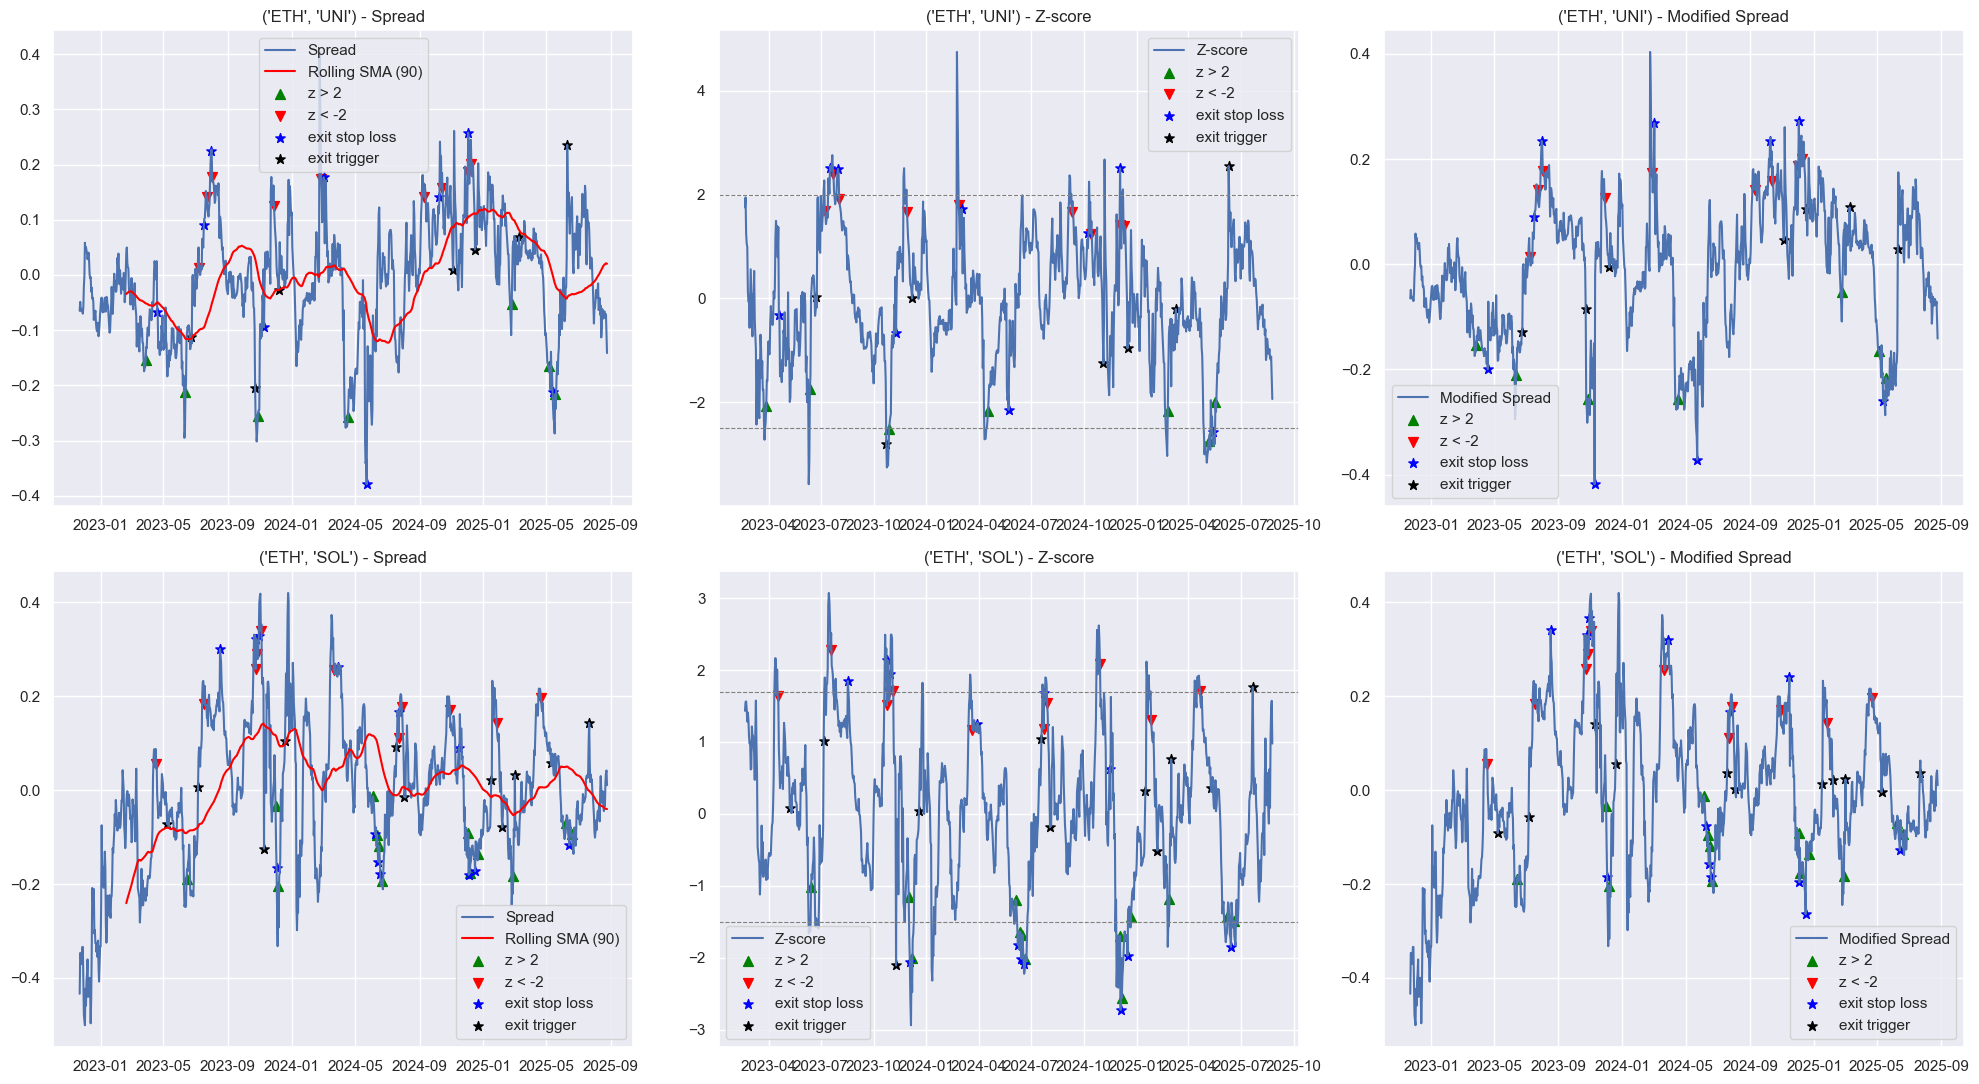

In [239]:
import matplotlib.pyplot as plt

n_rows = len(pairs)
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5.5 * n_rows), squeeze=False)

for row_idx, pair in enumerate(pairs):
    # Plot spread and moving averages
    ax_spread = axes[row_idx, 0]
    spread = signal_df[(pair, 'spread')]
    ax_spread.plot(spread, label='Spread')
    ax_spread.plot(spread.rolling(90, min_periods=90).mean(), label='Rolling SMA (90)', color='red')
    
    # Mark specific signals on the spread plot
    for signal_val, color, marker, label in [(1, 'green', '^', 'z > 2'),
                                             (-1, 'red', 'v', 'z < -2'),
                                             (6, 'blue', '*', 'exit stop loss'),
                                             (5, 'black', '*', 'exit trigger')]:
        mask = all_signals_df[pair] == signal_val
        ax_spread.scatter(z.index[mask], spread[mask], color=color, marker=marker, label=label, s=50)
    
    ax_spread.set_title(f'{pair} - Spread')
    ax_spread.legend()
    
    # Plot z-score with thresholds and signals
    ax_z = axes[row_idx, 1]
    z_score = signal_df[(pair, 'zs')]
    ax_z.plot(z_score, label='Z-score')
    lower_bound, upper_bound = bounds[pair]
    ax_z.axhline(y=lower_bound, color='grey', linestyle='--', linewidth=0.8)
    ax_z.axhline(y=upper_bound, color='grey', linestyle='--', linewidth=0.8)
    
    for signal_val, color, marker, label in [(1, 'green', '^', 'z > 2'),
                                             (-1, 'red', 'v', 'z < -2'),
                                             (6, 'blue', '*', 'exit stop loss'),
                                             (5, 'black', '*', 'exit trigger')]:
        mask = all_signals_df[pair] == signal_val
        ax_z.scatter(z.index[mask], z_score[mask], color=color, marker=marker, label=label, s=50)
    
    ax_z.set_title(f'{pair} - Z-score')
    ax_z.legend()
    
    # Plot modified spread with signals
    ax_mod_spread = axes[row_idx, 2]
    mod_spread = signal_df[(pair, 'modified_spread')]
    ax_mod_spread.plot(mod_spread, label='Modified Spread')
    
    for signal_val, color, marker, label in [(1, 'green', '^', 'z > 2'),
                                             (-1, 'red', 'v', 'z < -2'),
                                             (6, 'blue', '*', 'exit stop loss'),
                                             (5, 'black', '*', 'exit trigger')]:
        mask = all_signals_df[pair] == signal_val
        ax_mod_spread.scatter(z.index[mask], mod_spread[mask], color=color, marker=marker, label=label, s=50)
    
    ax_mod_spread.set_title(f'{pair} - Modified Spread')
    ax_mod_spread.legend()

plt.tight_layout()
plt.show()


In [217]:
SL_PERCENT = 0.05  # 5% stop-loss on gross entry notional
STARTING_CAPITAL = 1000000  # total capital to deploy per pair
FEE_RATE = 0.00045  # 0.045% fee per trade side (entry or exit)

all_positions = {}
all_pnl = {}
all_realized_pnl = {}
all_realized_pnl_curve = {}
all_fees_paid = {}

total_realized_pnl = 0.0
total_fees_paid = 0.0

for pair in pairs:
    total_realized_pnl = 0.0
    total_fees_paid = 0.0
    i_sym, j_sym = pair
    z      = signal_df[(pair, "zs")]
    log_i  = signal_df[(pair, "log_i")]
    log_j  = signal_df[(pair, "log_j")]
    alpha  = signal_df[(pair, "alpha")]
    beta   = signal_df[(pair, "beta")]
    spread = signal_df[(pair, "spread")]

    i_px = np.exp(log_i)
    j_px = np.exp(log_j)

    z_smooth = z.ewm(span=6, adjust=False).mean()
    d_ma = z_smooth.diff()
    turning_points = (d_ma.shift(1) * d_ma < 0)

    positions_df = pd.DataFrame(0.0, index=signal_df.index, columns=[i_sym, j_sym])
    pnl_series = pd.Series(0.0, index=signal_df.index)
    realized_pnl_curve = pd.Series(0.0, index=signal_df.index)

    state = None

    entry_alpha = None
    entry_beta = None
    entry_i_price = None
    entry_j_price = None
    entry_shares_i = 0.0
    entry_shares_j = 0.0
    entry_notional = 0.0
    entry_spread_mean = None
    entry_spread_std = None

    current_position_i = 0.0
    current_position_j = 0.0
    realized_pnl = 0.0
    fees_paid = 0.0
    

    for idx, timestamp in enumerate(signal_df.index):
        cur_z = z.iloc[idx]
        b = beta.iloc[idx]

        positions_df.loc[timestamp, i_sym] = current_position_i
        positions_df.loc[timestamp, j_sym] = current_position_j

        if pd.isna(cur_z) or pd.isna(b):
            pnl_series.loc[timestamp] = pnl_series.iloc[idx-1] if idx > 0 else 0.0
            continue

        if state is None:
            if cur_z > bounds[pair][0]:
                state = "pos_waiting"
            elif cur_z < bounds[pair][1]:
                state = "neg_waiting"

        elif state == "pos_waiting":
            if bool(turning_points.iloc[idx]) and cur_z > 1.0:
                entry_spread_mean = spread.rolling(window=90).mean().iloc[idx]
                entry_spread_std = spread.rolling(window=90).std().iloc[idx]
                entry_alpha = alpha.iloc[idx]
                entry_beta = b
                entry_i_price = i_px.iloc[idx]
                entry_j_price = j_px.iloc[idx]

                total_beta = abs(entry_beta) + 1.0
                notional_i = STARTING_CAPITAL * (abs(entry_beta) / total_beta)
                notional_j = STARTING_CAPITAL * (1.0 / total_beta)

                entry_shares_i = notional_i / entry_i_price
                entry_shares_j = -notional_j / entry_j_price

                entry_notional = notional_i + notional_j

                current_position_i = entry_shares_i
                current_position_j = entry_shares_j

                positions_df.loc[timestamp, i_sym] = current_position_i
                positions_df.loc[timestamp, j_sym] = current_position_j

                # Entry fees
                entry_fees = FEE_RATE * entry_notional * 2
                realized_pnl -= entry_fees
                fees_paid += entry_fees

                state = "short"

        elif state == "neg_waiting":
            if bool(turning_points.iloc[idx]) and cur_z < -1.0:
                entry_spread_mean = spread.rolling(window=90).mean().iloc[idx]
                entry_spread_std = spread.rolling(window=90).std().iloc[idx]
                entry_alpha = alpha.iloc[idx]
                entry_beta = b
                entry_i_price = i_px.iloc[idx]
                entry_j_price = j_px.iloc[idx]

                total_beta = abs(entry_beta) + 1.0
                notional_i = STARTING_CAPITAL * (abs(entry_beta) / total_beta)
                notional_j = STARTING_CAPITAL * (1.0 / total_beta)

                entry_shares_i = -notional_i / entry_i_price
                entry_shares_j = notional_j / entry_j_price

                entry_notional = notional_i + notional_j

                current_position_i = entry_shares_i
                current_position_j = entry_shares_j

                positions_df.loc[timestamp, i_sym] = current_position_i
                positions_df.loc[timestamp, j_sym] = current_position_j

                # Entry fees
                entry_fees = FEE_RATE * entry_notional * 2
                realized_pnl -= entry_fees
                fees_paid += entry_fees

                state = "long"

        if state in ("long", "short"):
            cur_i = i_px.iloc[idx]
            cur_j = j_px.iloc[idx]

            dollar_pnl = (cur_j - entry_j_price) * entry_shares_j + (cur_i - entry_i_price) * entry_shares_i
            pnl_series.loc[timestamp] = dollar_pnl

            max_loss_dollars = SL_PERCENT * entry_notional
            stop_hit = (dollar_pnl <= -max_loss_dollars)

            cur_spread = log_j.iloc[idx] - (entry_alpha + entry_beta * log_i.iloc[idx])
            signal_df.loc[timestamp, (pair, "modified_spread")] = cur_spread

            z_dyn = (cur_spread - entry_spread_mean) / entry_spread_std
            signal_df.loc[timestamp, (pair, "modified_zs")] = z_dyn

            mean_revert_exit = ((state == "long" and z_dyn >= -0.3) or
                               (state == "short" and z_dyn <= 0.3))

            if stop_hit or mean_revert_exit:
                realized_pnl += dollar_pnl
                exit_fees = FEE_RATE * entry_notional * 2
                realized_pnl -= exit_fees

                pnl_series.loc[timestamp] = dollar_pnl - exit_fees

                fees_paid += exit_fees

                current_position_i = 0.0
                current_position_j = 0.0
                positions_df.loc[timestamp, [i_sym, j_sym]] = 0.0

                state = None
                entry_alpha = entry_beta = None
                entry_i_price = entry_j_price = None
                entry_shares_i = entry_shares_j = 0.0
                entry_notional = 0.0
                entry_spread_mean = entry_spread_std = None

        else:
            pnl_series.loc[timestamp] = pnl_series.iloc[idx-1] if idx > 0 else 0.0
            realized_pnl_curve.loc[timestamp] = realized_pnl_curve.iloc[idx-1] if idx > 0 else 0.0

    all_positions[pair] = positions_df
    all_pnl[pair] = pnl_series
    all_realized_pnl[pair] = realized_pnl
    all_fees_paid[pair] = fees_paid

In [222]:
all_realized_pnl

{('ETH', 'UNI'): np.float64(133992.04629192105),
 ('ETH', 'SOL'): np.float64(531178.8195243215)}

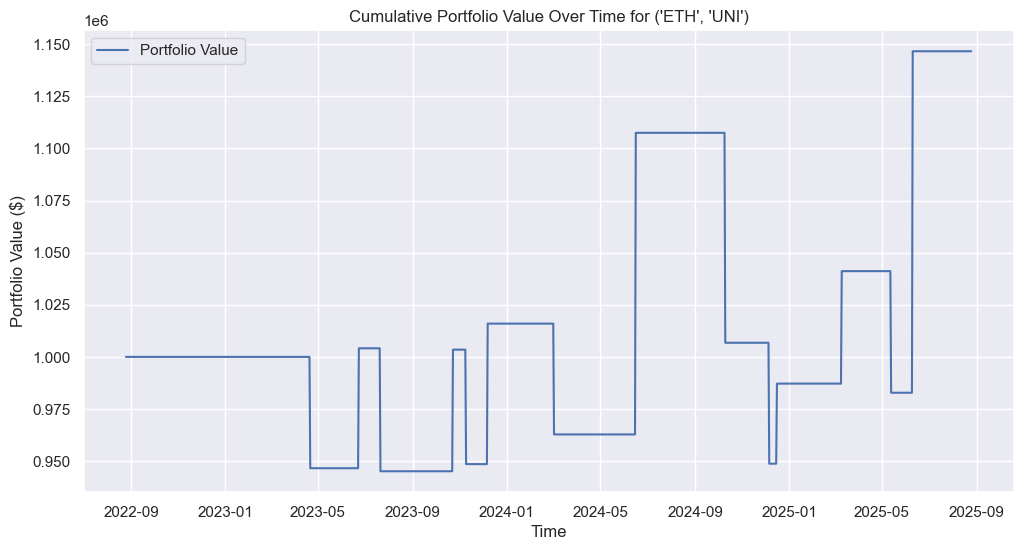

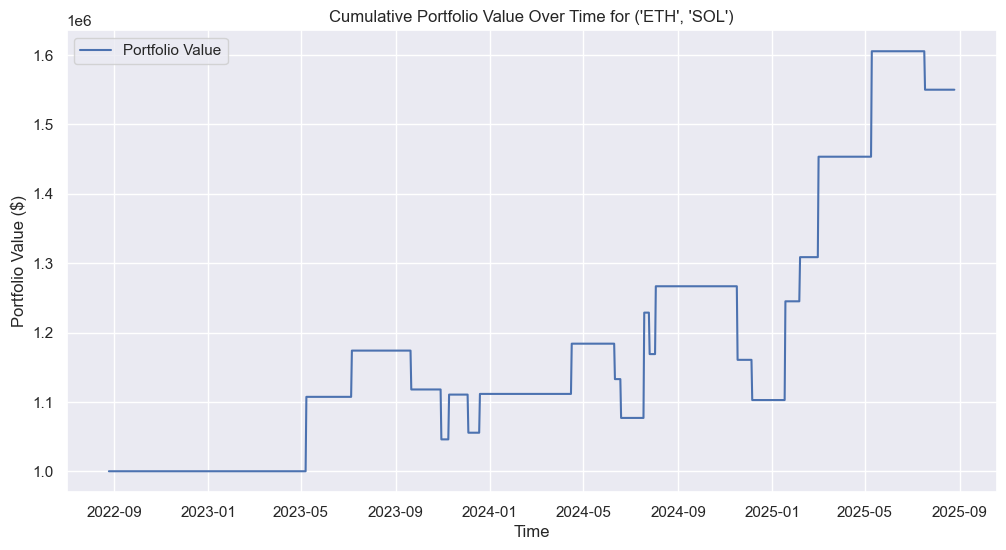

In [248]:
# Assume STARTING_CAPITAL is your initial capital
starting_capital = STARTING_CAPITAL
for pair in pairs:
    # Create a series to track cumulative realized PnL over time
    cumulative_realized_pnl = pd.Series(0.0, index=signal_df.index)

    # Track last cumulative value to fill forward
    last_cum_value = 0.0

    # Loop to fill cumulative realized PnL series at exits
    realized_sum = 0.0
    for idx, timestamp in enumerate(signal_df.index):
    # Check if current pnl_series value is zero and position is zero (indicates exit)
    # You may refine this condition to detect exact exit points if you have flags
    
    # Here we accumulate realized PnL manually at exit points
    # For simplicity we add pnl at times when position goes from nonzero to zero
        if idx > 0:
            prev_pos_i = all_positions[pair][pair[0]].iloc[idx-1]
            prev_pos_j = all_positions[pair][pair[1]].iloc[idx-1]
            cur_pos_i = all_positions[pair][pair[0]].iloc[idx]
            cur_pos_j = all_positions[pair][pair[1]].iloc[idx]

            exited = (prev_pos_i != 0 or prev_pos_j != 0) and (cur_pos_i == 0 and cur_pos_j == 0)

            if exited:
            #realized_sum += pnl_series.iloc[idx]
                realized_sum += all_pnl[pair].iloc[idx]

        cumulative_realized_pnl.iloc[idx] = realized_sum

    # Calculate total portfolio value over time
    portfolio_value = starting_capital + cumulative_realized_pnl

# Plot cumulative return as percent growth of capital
    plt.figure(figsize=(12,6))
    plt.plot(portfolio_value.index, portfolio_value.values, label='Portfolio Value')
    plt.title(f'Cumulative Portfolio Value Over Time for {pair}')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()